In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import time


training_path = "fruits-360_dataset/Training"
test_path = "fruits-360_dataset/Test"

try:
    STATS = np.load("stats.npy", allow_pickle=True)
except FileNotFoundError as fnf:
    print("Not found stats file.")
    STATS = []

# Parameters    
GRAY_SCALE = False
FRUITS = os.listdir(training_path)

random.shuffle(FRUITS)
LOAD_FACTOR = 0.2  # dont load all fruits


Not found stats file.


In [2]:
def load_data(directory_path, load_factor=None):
    data = []
    labels = []
               
            
    for fruit_name in FRUITS:
        class_num = FRUITS.index(fruit_name)                
        
        path = os.path.join(directory_path, fruit_name)
        
        for img in os.listdir(path):
            if load_factor and np.random.random() > load_factor:  # skip image
                continue
                
            img_path = os.path.join(path, img)    
            if GRAY_SCALE:
                image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            else:
                image = cv2.imread(img_path)
                image = image[:, :, [2, 1, 0]]
                
#             image = tf.keras.utils.normalize(image)  # This is bad in our scenario
            image = image / 255.0
            data.append([image, class_num])

    random.shuffle(data)
        
    X = []
    y = []
    
    
    for image, label in data:
        X.append(image)
        y.append(label)
    
    X = np.array(X)
    y = np.array(y)
    
    if GRAY_SCALE:
        print("Reshaping gray scale")
        X = X.reshape(-1, X.shape[1], X.shape[2], 1)
        
    return X, y      

In [3]:
X_training, y_training = load_data(training_path, load_factor=0.3)
print("\nCreated training array")    
print(f"X shape: {X_training.shape}")
print(f"y shape: {y_training.shape}")


Created training array
X shape: (18286, 100, 100, 3)
y shape: (18286,)


In [4]:
# Limit gpu memory usage
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = False
config.gpu_options.per_process_gpu_memory_fraction = 0.25
sess = tf.compat.v1.Session(config=config)

In [5]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, Activation, Dropout

pic_shape = X_training.shape[1:]
label_count = len(FRUITS)

print(f"Pic shape: {pic_shape}")

# Input
model = tf.keras.models.Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=pic_shape),
    MaxPooling2D(pool_size=(2, 2)),
    
    Dropout(0.15),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Dropout(0.15),
    
    Flatten(),
    Dense(32, activation='relu'),
    Dense(label_count, activation='softmax')    
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Pic shape: (100, 100, 3)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
flatten (Flatten)            (N

In [6]:
training_history = model.fit(X_training, y_training, batch_size=20, epochs=10)

Train on 18286 samples
Epoch 1/10
18286/18286 [==============================] - 16s 873us/sample - loss: 1.6499 - accuracy: 0.5842
Epoch 2/10
18286/18286 [==============================] - 13s 693us/sample - loss: 0.1779 - accuracy: 0.9447
Epoch 3/10
18286/18286 [==============================] - 13s 698us/sample - loss: 0.0949 - accuracy: 0.9707
Epoch 4/10
18286/18286 [==============================] - 13s 699us/sample - loss: 0.0795 - accuracy: 0.9771
Epoch 5/10
18286/18286 [==============================] - 13s 697us/sample - loss: 0.0692 - accuracy: 0.9785
Epoch 6/10
18286/18286 [==============================] - 13s 696us/sample - loss: 0.0366 - accuracy: 0.9890
Epoch 7/10
18286/18286 [==============================] - 13s 695us/sample - loss: 0.0694 - accuracy: 0.9781
Epoch 8/10
18286/18286 [==============================] - 13s 694us/sample - loss: 0.0446 - accuracy: 0.9882
Epoch 9/10
18286/18286 [==============================] - 13s 702us/sample - loss: 0.0518 - accuracy: 0.9

In [7]:
X_training = None
y_training = None
time.sleep(1)

In [8]:
X_test, y_test = load_data(test_path, load_factor=0.3)

print("\nCreated test array")    
print(f"X shape: {X_test.shape}")
print(f"y shape: {y_test.shape}")


Created test array
X shape: (6140, 100, 100, 3)
y shape: (6140,)


6140/6140 [==============================] - 2s 313us/sample - loss: 0.3563 - accuracy: 0.9406
Test Accuracy: 0.9406
Test loss: 0.3563


/home/greg/anaconda3/envs/gym/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


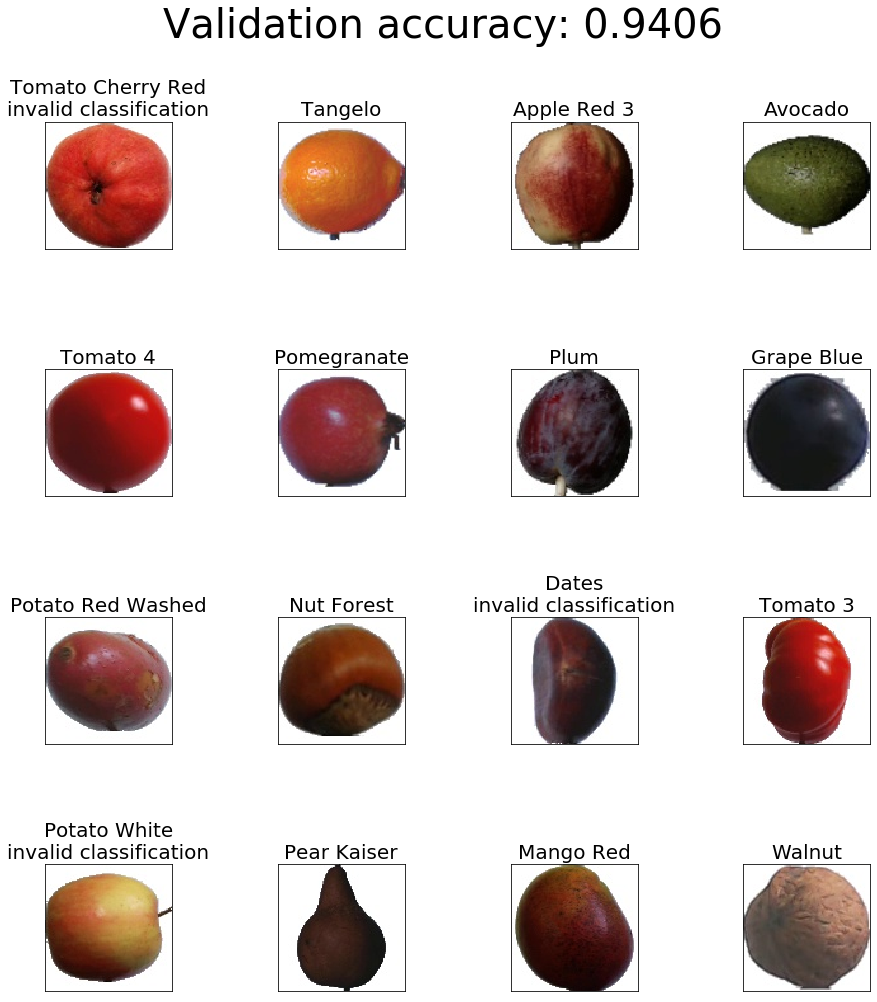

In [9]:
loss, accuracy = model.evaluate(X_test, y_test)
predictions = model.predict(X_test)

print(f"Test Accuracy: {accuracy:>2.4f}")
print(f"Test loss: {loss:>2.4f}")

fig = plt.figure(figsize=(16, 16))

for x in range(1,17):
    class_num = np.argmax(predictions[x])
    valid = y_test[x] == class_num
    ax = fig.add_subplot(4, 4, x)
    ax.imshow(X_test[x])
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
    title = FRUITS[class_num] + ("\ninvalid classification" if not valid else "")
    ax.set_title(title, size=20)

fig.subplots_adjust(hspace=0.95)
fig.suptitle(f"Validation accuracy: {accuracy:>2.3f}, samples: {len()}", size=40)
fig.savefig("last-validation.png")
fig.show()

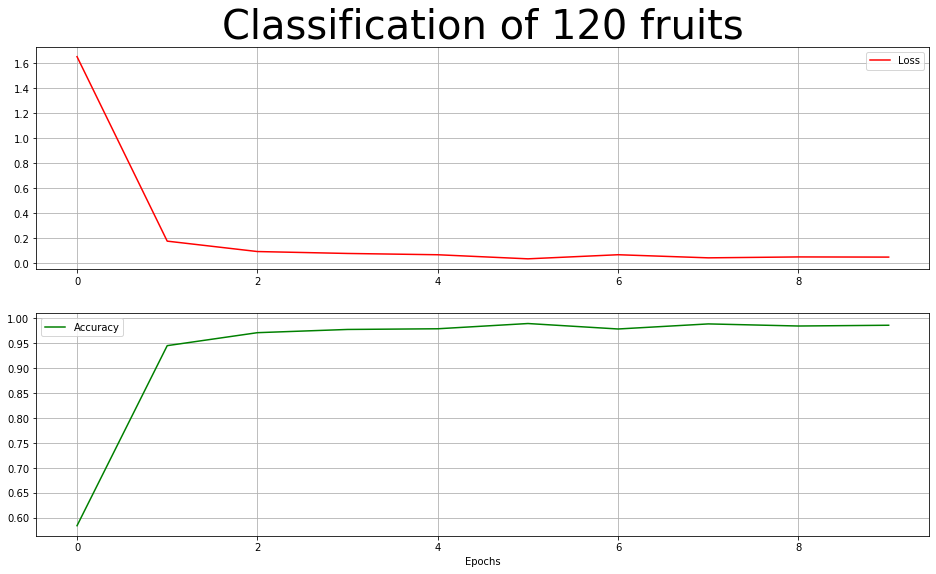

In [10]:
SMOOTH = False

epochs = training_history.epoch
loss = training_history.history['loss']
acc = training_history.history['accuracy']

if SMOOTH:    
    from scipy.interpolate import CubicSpline
    cs_loss = CubicSpline(epochs, loss)
    cs_acc = CubicSpline(epochs, acc)
    
    x = np.linspace(0, epochs[-1], 100)
    y_loss = cs_loss(x)
    y_acc = cs_acc(x)

else:
    x = epochs
    y_loss = loss
    y_acc = acc
    
plt.figure(figsize=(16,9))

ax1 = plt.subplot(2,1,1)
plt.title(f"Classification of {len(FRUITS)} fruits", size=40)
plt.plot(y_loss, label='Loss', c='r')
plt.legend(loc='best')
plt.grid()

plt.subplot(2,1,2)
plt.plot(y_acc, label='Accuracy', c='g')
plt.legend(loc='best')
plt.xlabel("Epochs")
plt.grid()

pic_name = ax1.get_title().replace(' ', '-')
plt.savefig(f"{pic_name}.png")

plt.show()